Chapter Outline:
    1. Recap
    2. Chapter Goals
    3. GMM intuition
    4. ...
    5. Conclusions

In [3]:
%load_ext watermark
%watermark

from IPython.display import display

# import standard libs
from pathlib import PurePath, Path
import sys
import time

# get project dir
pp = PurePath(Path.cwd()).parts[:-1]
pdir = PurePath(*pp)
script_dir = pdir / 'scripts' 
sys.path.append(script_dir.as_posix())

# import python scientific stack
import pandas as pd
#pd.options.display.float_format = '{:,.4f}'.format
import pandas_datareader.data as web
import numpy as np
import sklearn.mixture as mix
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as stats

# import visual tools

from mpl_toolkits import mplot3d
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import plotnine as pn
import mizani.breaks as mzb
import mizani.formatters as mzf
import seaborn as sns

# import util libs
import pyarrow as pa
import pyarrow.parquet as pq
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from utils import cprint

# set plot globals
plt.style.use('bmh') #seaborn-ticks')
plt.rcParams['font.family'] = 'DejaVu Sans Mono'
plt.rcParams['font.size'] = 9.5
plt.rcParams['font.weight'] = 'medium'
plt.rcParams['figure.figsize'] = 10,7
#plt.rcParams['axes.facecolor'] = sns.xkcd_rgb['gunmetal']

blue, green, red, purple, gold, teal = sns.color_palette('colorblind', 6)
RANDOM_STATE = 777

print()
%watermark -p pandas,pandas_datareader,numpy,sklearn,statsmodels,scipy,matplotlib,seaborn,plotnine,pyarrow

2017-12-01T18:25:51-07:00

CPython 3.6.2
IPython 6.1.0

compiler   : GCC 4.8.2 20140120 (Red Hat 4.8.2-15)
system     : Linux
release    : 4.10.0-38-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 12
interpreter: 64bit


/home/bcr/anaconda3/envs/pymc3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools



pandas 0.21.0
pandas_datareader 0.5.0
numpy 1.13.1
sklearn 0.19.0
statsmodels 0.8.0
scipy 1.0.0
matplotlib 2.1.0
seaborn 0.8.1
plotnine 0.3.0+9.g6519baa
pyarrow 0.7.1


## 1. Recap

In the last chapter we went through some foundational concepts. 

We discussed stationarity, why it is important, and its rules. We were able to understand the concept by thoroughly examining the most common ways that financial time series violate the requirements. 

We illustrated how financial time series have trends _(means vary with time)_, changing volatility _(variance changes with time)_, clustering volatility _(autocorrelation between t and t+i)_.

Using statistical techniques we demonstrated that asset returns from different time periods and scales appear to come from different distributions.

We concluded that for our purposes of predicting future return distributions, techniques that cannot accomodate the time varying properties of financial asset returns are a danger to our trading acocunts.

## 2. Chapter Goals

In this chapter we will see how Gaussian Mixture Models (gmm) can help overcome some of the time series prediction issues we identified in chapter 1.

1. Understand how GMM's can approximate nonstationary distributions
2. Use `sklearn` to choose the optimal number of components
3. Use `seaborn, plotnine`, and `matplotlib` for visual analysis


## 3. Gaussian Mixture Models (GMM) Intuition


Our biggest pain point results from the idea that asset returns are comprised of multiple distributions. Time varying means, and volatilities can be considered as coming from different distributions, regimes, or states _(moving forward I will use those terms interchangeably)_. Each regime has its own parameters. 

For example consider two regimes with the following characteristics.
    
    1. Stable, low volatility
    2. Risky, high(er) volatility

We can make an assumption that every data point from our return series has come from either the _stable_ or _risky_ regime. If we can classify each data point correctly then we can use the current regime's parameters as the input to our prediction for the next period. _As we know, the best estimate for an unpredictable future state is the current state._

That sounds good however we still have some challenges. 

1. We do not know the parameters, ($\mu, \sigma$), for the two regimes. 
2. We do not know which datapoint came from which regime.

On first pass this problem seems intractable. 

Fortunately for us, some smart people devised a solution. 

> __Expectation-maximization algorithm (EM, E-M, em, etc.)__

Most introductory texts on this subject explain the topic using heavy maths first, somewhat obscuring the concept and leaving one feeling like its _magic_ and moving on. I hope to avoid that outcome in this brief intro and make it more intuitive. 

#### Why do we need EM, why bother to understand it?

The EM algorithm and derivations thereof underpin many unsupervised learning methods including mixture modeling. It is useful in many real world applications where:

    - Data is corrupted.
    - Data is missing.
    - We do not know the parameters of data generating process (aka model, distribution).
    - We do not know which data generating process generated which data point.
    
Let's continue with our example of an asset return series being generated by a combination of 2 Gaussian distributions. To start we let's say we have `3 trading years (252*3)` worth of return data. 

To start the algorithm all we have to do is guess at the parameters even though we know __those guesses are likely incorrect__.

For example we can assume the stable regime has returns with mean `2.5%` and sigma `9%`, while the risky regime has `-1.0%` returns and `25%` volatility. Furthermore we will assume that each regime occurs with equal probability.

The next step is to assume those incorrect guesses are correct and proceed to assign probabilities aka weights aka responsiblities to each data point. So for example assume the first data point we have is a return of `1.3%`. We must compute the probability that a Gaussian distribution with mean `2.5%` and std of `9%` generated that return. Because we only have two regimes the probability that the `risky` regime generated the datapoint is $1 - P_{stable}$. We do that for all the returns on the first pass, again reusing those initial incorrect guesses about the means and volatilties.

Now we use those assignments to reestimate the means and volatilities of the regimes. Rinse and repeat. 

What's remarkable about this iterative process is that we are guaranteed to improve our estimate at each iteration. 

_Note: this algorithm **does not** guarantee a global solution, but rather a local one. In practice the algorithm is started with multiple random parameter initializations in order to recover the best estimates of the true parameters._


For this example let's assume we have deduced the true means, sigmas, and prior probabilities for each of the distributions, and we want to test the ability of the EM algorithm to recover this information from noisy data.

To set up this brief demonstration below we define the number of samples `n`, the true means, and sigmas, as well as the true prior probability of each regime. 

In [4]:
# Let's create some example return data to walk through the process. We will create a synthetic return series composed of two gaussians with different parameters. 
n = 252 * 3

true_stable_mu, true_stable_sigma = 0.05, 0.15
true_risky_mu, true_risky_sigma = -0.025, 0.30

true_prob_stable = 0.65
true_prob_risky = 1 - true_prob_stable

true_mus = np.array([true_stable_mu, true_risky_mu])
true_sigmas = np.array([true_stable_sigma, true_risky_sigma])
true_probs = np.array([true_prob_stable, true_prob_risky])

Then we create a little helper fun that takes our true parameters and creates a noisy, synthetic _(fake)_ return series by **mixing** our true distributions. 

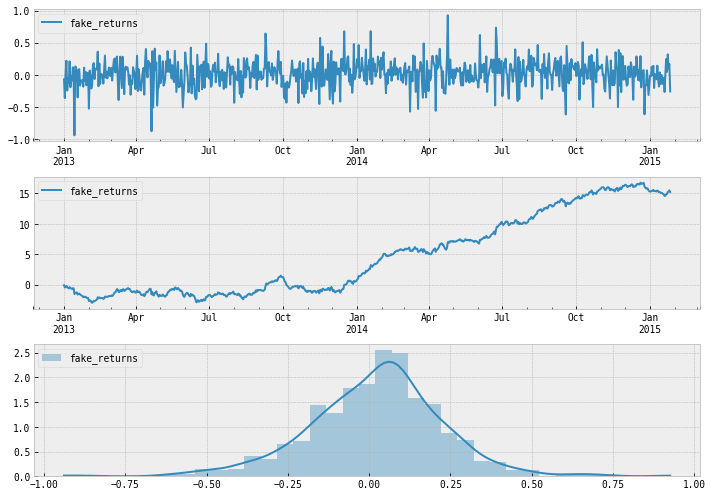

In [5]:
def mix_data(mus, sigmas, probs, n):

    np.random.seed(0)
    # randomly sample from binomial to select distr.
    z = np.random.binomial(1, true_probs[1], n)
    # sample from normal distr. and associated parameters according to z
    X = np.random.normal(true_mus[z], true_sigmas[z])
    
    # fake dates to make it look real
    fake_dates = pd.date_range('2013', periods=n)
    fake_returns = pd.Series(X, index=fake_dates)
    
    return fake_returns

mixed = mix_data(true_mus, true_sigmas, true_probs, n=n)

fig, axs = plt.subplots(nrows=3, figsize=(10,7))#, sharex=True)

mixed.plot(ax=axs[0], label='fake_returns')
mixed.cumsum().plot(ax=axs[1], label='fake_returns')
sns.distplot(mixed, ax=axs[2], kde_kws=dict(cut=0), label='fake_returns')
for ax in axs: ax.legend(loc='upper left')
plt.tight_layout()

After creating our somewhat realistic looking mixture we need to code our normal distribution class. 

It needs to be able to take mu, sigma parameters and contain methods to compute the log probability density function (logpdf, or log_density) of the data given the parameters. It also needs to be able to estimate the parameters of the normal distribution given the data and weights.

In [6]:
# code adapted from: https://github.com/sseemayer/mixem

class N:
    """Univariate normal distribution with parameters (mu, sigma)."""

    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma

    def log_density(self, data):
        """fn: compute log pdf of normal distr. given parameters and data"""
        
        assert(len(data.shape) == 1), "Expect 1D data!"

        return - (data - self.mu) ** 2 / (2 * self.sigma ** 2) - np.log(self.sigma) - 0.5 * np.log(2 * np.pi)

    def estimate_parameters(self, data, weights):
        """fn: estimate parameters of normal distr. given data and weights"""
        
        assert(len(data.shape) == 1), "Expect 1D data!"

        wsum = np.sum(weights)

        self.mu = np.sum(weights * data) / wsum
        self.sigma = np.sqrt(np.sum(weights * (data - self.mu) ** 2) / wsum)    

Now we can make incorrect guesses about the parameters of the two distributions as initial starting points to the EM algorithm. 

In [7]:
# terrible guesses at the true prior probability
init_stable_prob = 0.5
init_volatile_prob = 0.5

# guesses at starting mean
init_stable_mean = 0.10
init_volatile_mean = -0.025

# guesses at starting std
init_stable_std = 0.10
init_volatile_std = 0.20

init_probs = np.array([init_stable_prob, init_volatile_prob])
init_means = np.array([init_stable_mean, init_volatile_mean])
init_sigmas = np.array([init_stable_std, init_volatile_std])

Now we are ready to code the actual algorithm steps. Code is adapted from [here](https://github.com/sseemayer/mixem/blob/master/mixem/em.py)

In [8]:
# wrap our distributions in a list
distributions = [N(init_means[0], init_sigmas[0]), 
                 N(init_means[1], init_sigmas[1])]
# set data
data = mixed.copy()    

# set algorithm parameters
max_iterations = tol_iters = 550
tol=1e-5

# get key dim info
n_distr = true_mus.shape[0]
n_data = data.shape[0]

weight = np.array(init_probs) # init weight array
last_ll = np.zeros((tol_iters, )) # init log-likelihood array
resp = np.empty((n_data, n_distr)) # init algo weights/resp array
log_density = np.empty((n_data, n_distr)) # init logpdf array

iteration = 0 # init counter

while True:
    # ---------------------------------------------------------
    # E-step 
    # ---------------------------------------------------------
    
    # compute responsibilities aka weights
    for d in range(n_distr):
        log_density[:, d] = distributions[d].log_density(data)
        
    # normalize responsibilities of distributions so they sum up to one for example
    resp = weight[np.newaxis, :] * np.exp(log_density)
    resp /= np.sum(resp, axis=1)[:, np.newaxis]
    
    # compute log-likelihood
    log_likelihood = np.sum(resp @ log_density.T) # matrix multiplication?
    
    # ---------------------------------------------------------
    # M-step 
    # ---------------------------------------------------------
    
    for d in range(n_distr):
        distributions[d].estimate_parameters(data, resp[:, d])

    weight = np.mean(resp, axis=0)
    
    # ---------------------------------------------------------
    # check convergence
    # ---------------------------------------------------------
    
    if np.isnan(log_likelihood):
        last_ll[0] = log_likelihood
        break

    if iteration >= tol_iters and (last_ll[-1] - log_likelihood) / last_ll[-1] <= tol:
        last_ll[0] = log_likelihood
        break

    if iteration >= max_iterations:
        last_ll[0] = log_likelihood
        break

    # ---------------------------------------------------------
    # store value of current iteration in last_ll[0]
    #   and shift older values to the right
    # ---------------------------------------------------------    
    last_ll[1:] = last_ll[:-1]
    last_ll[0] = log_likelihood
    
    # ---------------------------------------------------------
    # info display
    # ---------------------------------------------------------    
    mus = np.array([distributions[i].mu for i in range(n_distr)])
    sigs = np.array([distributions[i].sigma for i in range(n_distr)])
    
    regime_map = {0:'stable', 1:'risky'}
    iter_data = (pd.DataFrame(np.vstack([mus, sigs, weight,
                                         true_mus, true_sigmas, true_probs]),
                              columns=[f'{regime_map[i]} regime' for i in range(n_distr)],
                              index=['means', 'sigmas', 'weights',
                                     'true_means', 'true_sigmas', 'true_weights'])
                 .round(3))
    
    if iteration % 50==0:
        print()
        print('-'*77)
        print(f'iteration: {iteration}')
        print(f"ll new: {last_ll[0].round(3)}")
        display(iter_data.T)
    iteration += 1        


-----------------------------------------------------------------------------
iteration: 0
ll new: -228381.861


,means,sigmas,weights,true_means,true_sigmas,true_weights
stable regime,0.094,0.110,0.44,0.050,0.15,0.65
risky regime,-0.037,0.244,0.56,-0.025,0.30,0.35



-----------------------------------------------------------------------------
iteration: 50
ll new: -19134.81


,means,sigmas,weights,true_means,true_sigmas,true_weights
stable regime,0.046,0.131,0.525,0.050,0.15,0.65
risky regime,-0.009,0.264,0.475,-0.025,0.30,0.35



-----------------------------------------------------------------------------
iteration: 100
ll new: -3782.573


,means,sigmas,weights,true_means,true_sigmas,true_weights
stable regime,0.043,0.139,0.596,0.050,0.15,0.65
risky regime,-0.013,0.275,0.404,-0.025,0.30,0.35



-----------------------------------------------------------------------------
iteration: 150
ll new: 3901.633


,means,sigmas,weights,true_means,true_sigmas,true_weights
stable regime,0.041,0.143,0.634,0.050,0.15,0.65
risky regime,-0.016,0.282,0.366,-0.025,0.30,0.35



-----------------------------------------------------------------------------
iteration: 200
ll new: 7825.76


,means,sigmas,weights,true_means,true_sigmas,true_weights
stable regime,0.040,0.145,0.654,0.050,0.15,0.65
risky regime,-0.017,0.286,0.346,-0.025,0.30,0.35



-----------------------------------------------------------------------------
iteration: 250
ll new: 9836.579


,means,sigmas,weights,true_means,true_sigmas,true_weights
stable regime,0.039,0.146,0.664,0.050,0.15,0.65
risky regime,-0.018,0.288,0.336,-0.025,0.30,0.35



-----------------------------------------------------------------------------
iteration: 300
ll new: 10867.023


,means,sigmas,weights,true_means,true_sigmas,true_weights
stable regime,0.039,0.147,0.67,0.050,0.15,0.65
risky regime,-0.019,0.289,0.33,-0.025,0.30,0.35



-----------------------------------------------------------------------------
iteration: 350
ll new: 11394.855


,means,sigmas,weights,true_means,true_sigmas,true_weights
stable regime,0.039,0.147,0.672,0.050,0.15,0.65
risky regime,-0.019,0.290,0.328,-0.025,0.30,0.35



-----------------------------------------------------------------------------
iteration: 400
ll new: 11665.142


,means,sigmas,weights,true_means,true_sigmas,true_weights
stable regime,0.039,0.148,0.674,0.050,0.15,0.65
risky regime,-0.019,0.290,0.326,-0.025,0.30,0.35



-----------------------------------------------------------------------------
iteration: 450
ll new: 11803.52


,means,sigmas,weights,true_means,true_sigmas,true_weights
stable regime,0.039,0.148,0.674,0.050,0.15,0.65
risky regime,-0.019,0.290,0.326,-0.025,0.30,0.35



-----------------------------------------------------------------------------
iteration: 500
ll new: 11874.358


,means,sigmas,weights,true_means,true_sigmas,true_weights
stable regime,0.039,0.148,0.675,0.050,0.15,0.65
risky regime,-0.019,0.290,0.325,-0.025,0.30,0.35


Not bad right? This algorithm is pretty flexible although you can adjust the true parameters and/or the guesses and you will find some of the limitations. However how those are addressed are beyond the scope of this chapter.

My goal was to provide a simple working example of the algorithm, in order for us to gain a deeper understanding of what is happening inside the black box of the algorithm. 

Now we can move forward.

In [9]:
load_parquet = lambda fp: (pq.read_table(fp).to_pandas().assign(year=lambda df: df.index.year))

load_fp = PurePath(pdir, 'data/etf_returns_2004-11-19-2017-09-29.parquet').as_posix()
rdf = load_parquet(load_fp)
cprint(rdf)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                 EEM       EFA       GLD       QQQ       SPY       TLT  year
Date                                                                        
2017-09-25 -0.017113 -0.005719  0.010413 -0.010588 -0.002047  0.006240  2017
2017-09-26 -0.002694 -0.002208 -0.011225  0.002588  0.000602 -0.001813  2017
2017-09-27 -0.003603  0.000737 -0.009465  0.008970  0.003887 -0.015183  2017
2017-09-28 -0.000677  0.002647  0.001884 -0.000346  0.001199 -0.002968  2017
2017-09-29  0.011447  0.005858 -0.005168  0.007176  0.003509  0.002247  2017
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3238 entries, 2004-11-19 to 2017-09-29
Data columns (total 7 columns):
EEM     3238 non-null float64
EFA     3238 non-null float64
GLD     3238 non-null float64
QQQ     3238 n

In [10]:
def add_mean_std_text(x, **kwargs):
    """fn: add mean, std text to seaborn plot
    
    # Args
        x : pd.Series()
    """
    mean, std = x.mean(), x.std()
    mean_tx = f"mean: {mean:.4%}\nstd: {std:.4%}"
    
    txkw = dict(size=14, fontweight='medium', color='k', rotation=0)
    ymin, ymax = plt.gca().get_ylim()
    plt.text(mean+0.025, 0.8*ymax, mean_tx, **txkw)
    return

def plot_dist(rs, ex):
    """fn: to plot single distro with fitted histograms using FacetGrid
    
    # Args
        rs : pd.DataFrame(), return df
        ex : str(), security/column name
    """    
    g = (rs
         .pipe(sns.FacetGrid, 
               size=5,
               aspect=1.5)
         .map(sns.distplot, ex, kde=False, fit=stats.norm,
               hist_kws={'alpha':1}, 
              fit_kws={'color':blue, 'lw':2.5, 'label':'norm'})
         .map(sns.distplot, ex, kde=False, hist_kws={'alpha':None}, fit=stats.laplace,
              fit_kws={'linestyle':'--', 'color':purple, 'lw':2.5, 'label':'laplace'})
         .map(sns.distplot, ex, kde=False, hist_kws={'alpha':None}, fit=stats.johnsonsu,
              fit_kws={'linestyle':'-', 'color':red, 'lw':2.5, 'label':'jsu'})
         .map(add_mean_std_text, ex))
    g.add_legend()
    sns.despine(offset=1)
    plt.title(f'{ex} returns')
    return
    
def plot_facet_hist(rs, ex):
    """fn: to plot multiple fitted histograms using FacetGrid
    
    # Args
        rs : pd.DataFrame(), return df
        ex : str(), security/column name
    """
    df = rs.assign(year=lambda df: df.index.year)
    g = (sns.FacetGrid(df, col='year',col_wrap=2, size=4, aspect=1.2) # make sure to add legend
         .map(sns.distplot, ex, kde=False, fit=stats.norm,
              fit_kws={'color':blue, 'lw':2.5, 'label':'norm'})
         .map(sns.distplot, ex, kde=False, fit=stats.laplace,
              fit_kws={'linestyle':'--', 'color':purple, 'lw':2.5, 'label':'laplace'})
         .map(sns.distplot, ex, kde=False, fit=stats.johnsonsu,
              fit_kws={'linestyle':'-', 'color':red, 'lw':2.5, 'label':'jsu'})
         .map(add_mean_std_text, ex))

    g.add_legend()
    g.fig.subplots_adjust(hspace=.20)
    sns.despine(offset=1)
    return

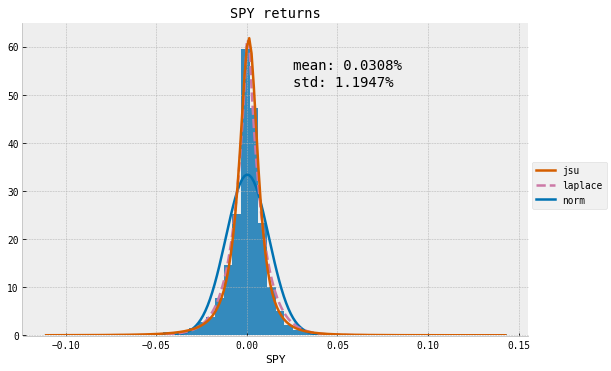

In [11]:
sym = 'SPY' # example symbol
df = rdf.loc['2005':].copy() # use 2005 cutoff b/c it's first full year of data

plot_dist(df, sym)

- `briefly introduce the chosen method for model evaluation and touch on the logic for why (AIC, BIC, DWAIC)`
- `start with sklearn demo using gaussian mixture with 1 component as example of fitting 1 normal distribution to the dataset, plot the densities`
- `then move to 2, 3, 4, N components`
- `discuss that in the limit, every data point can be fit with Gaussian with what effects on the mean and variance? but will certainly be overfit`
- `after provide bonus or appendix that describes the underlying expectation maximization algorithm`

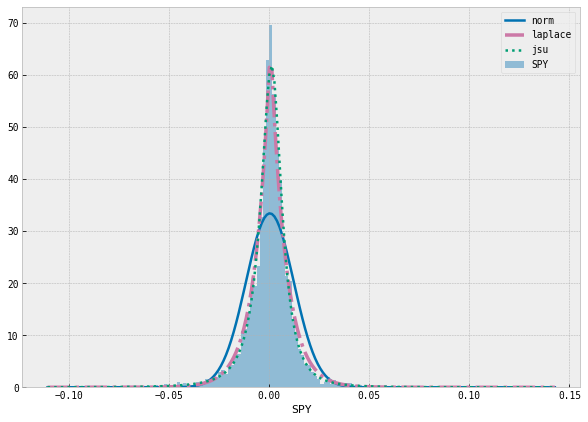

In [12]:
fig, ax = plt.subplots()

s = df[sym]

ax.hist(s, alpha=0.5, bins=150, normed=True);

sns.distplot(s, ax=ax, hist=False, kde=False, fit=stats.norm,
             fit_kws={'linestyle':'-', 'color':blue, 'lw':2.5, 'label':'norm'})
sns.distplot(s, ax=ax, hist=False, kde=False, fit=stats.laplace, 
             fit_kws={'linestyle':'-.', 'color':purple, 'lw':3.5, 'label':'laplace'})
sns.distplot(s, ax=ax, hist=False, kde=False, fit=stats.johnsonsu,
             fit_kws={'linestyle':':', 'color':green, 'lw':2.5, 'label':'jsu'})

ax.legend()

preprocess data

In [13]:
X = s.reshape(-1,1)
s[:5], X[:5]

(Date
 2005-01-03   -0.004727
 2005-01-04   -0.012295
 2005-01-05   -0.006924
 2005-01-06    0.005072
 2005-01-07   -0.001434
 Name: SPY, dtype: float64, array([[-0.00472662],
        [-0.01229483],
        [-0.00692446],
        [ 0.00507168],
        [-0.00143446]]))

In [14]:
def make_gmm(n_components, max_iter, random_state=RANDOM_STATE):
    """fn: create gmm object"""
    model_kwds = dict(n_components=n_components, max_iter=max_iter,
                      random_state=RANDOM_STATE)

    gmm = mix.GaussianMixture(**model_kwds)
    return gmm

RANDOM_STATE = 777
k = 1
max_iter = 150 

gmm1 = make_gmm(k, max_iter)

In [15]:
gmm1.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=150,
        means_init=None, n_components=1, n_init=1, precisions_init=None,
        random_state=777, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [16]:
preds = gmm1.predict(X)

In [17]:
gmm1.means_, gmm1.covariances_

(array([[ 0.00030842]]), array([[[ 0.00014369]]]))

In [18]:
gmm1.bic(X)

-19292.246386802919

In [19]:
gmm2 = make_gmm(2, max_iter)
gmm2.fit(X)
gmm2.predict(X)
gmm2.means_, gmm2.covariances_, gmm2.bic(X)

(array([[-0.00263246],
        [ 0.00089767]]), array([[[  6.14422437e-04]],
 
        [[  4.72895216e-05]]]), -20438.972104693737)

In [20]:
gmm10 = make_gmm(10, max_iter)
gmm10.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=150,
        means_init=None, n_components=10, n_init=1, precisions_init=None,
        random_state=777, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [21]:
gmm10.means_, gmm10.covariances_, gmm10.bic(X)

(array([[ 0.00174487],
        [-0.02127485],
        [ 0.03218533],
        [-0.07698017],
        [-0.00239338],
        [ 0.01576889],
        [ 0.12303798],
        [-0.04190984],
        [ 0.00767909],
        [-0.01028666]]), array([[[  8.60805439e-06]],
 
        [[  3.37830536e-05]],
 
        [[  1.60395923e-04]],
 
        [[  2.36984238e-04]],
 
        [[  1.01469164e-05]],
 
        [[  2.24100205e-05]],
 
        [[  1.58469532e-04]],
 
        [[  6.75960043e-05]],
 
        [[  1.22318000e-05]],
 
        [[  1.49550740e-05]]]), -20410.842140456374)

In [22]:
def make_ic_series(list_of_tups, name=None):
    """fn: convert list of tuples for 
            information criterion (aic, bic) into series
    # args
        list_of_tups : list() of tuples()
            tuple[0] is n_component, tuple[1] is IC
        name : str(), name of IC
    
    # returns
        s : pd.Series()
            index is n_components, values are IC's
    """
    s = (pd.DataFrame(list_of_tups)
          .rename(columns={0:'n_components', 1:name})
          .set_index('n_components')
          .squeeze())
    return s

In [23]:
# iterate over each symbol outputting the bic aic plot below, maybe gridspec it?

CPU times: user 1.89 s, sys: 7.42 s, total: 9.31 s
Wall time: 822 ms


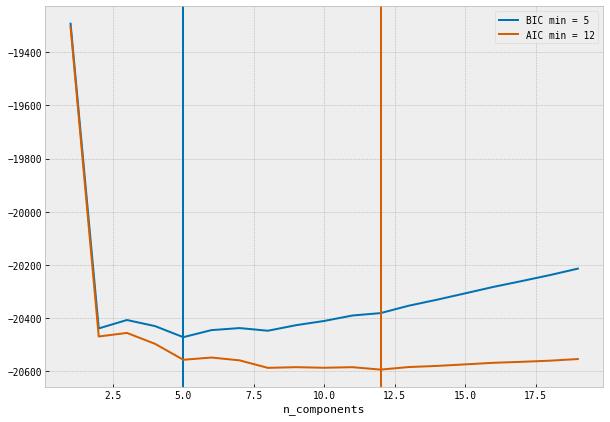

In [24]:
%%time 

n_components = np.arange(1,20)
aics = []
bics = []

for n in n_components:
    tmp_gmm = make_gmm(n, max_iter).fit(X)
    aics.append((n, tmp_gmm.aic(X)))
    bics.append((n, tmp_gmm.bic(X)))

bics = make_ic_series(bics, 'bic')
aics = make_ic_series(aics, 'aic')
    
plt.plot(n_components, bics.values, color=blue, label=f'BIC min = {np.argmin(bics)}')
plt.axvline(np.argmin(bics), color=blue)

plt.plot(n_components, aics.values, color=red, label=f'AIC min = {np.argmin(aics)}')
plt.axvline(np.argmin(aics), color=red)

plt.legend(loc='best')
plt.xlabel('n_components');

In [25]:
from matplotlib.dates import YearLocator, MonthLocator
from sklearn.model_selection import TimeSeriesSplit

# maybe gridspec plots below??

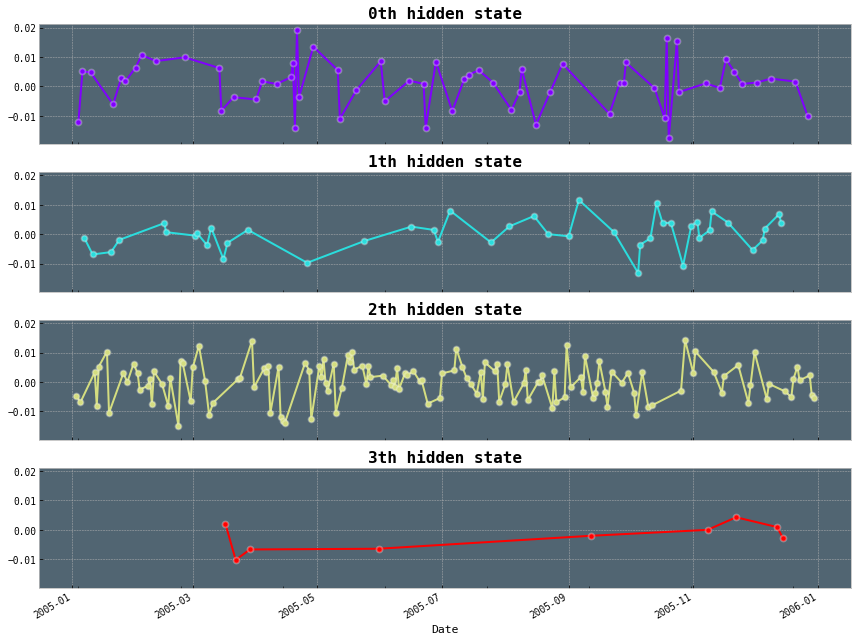

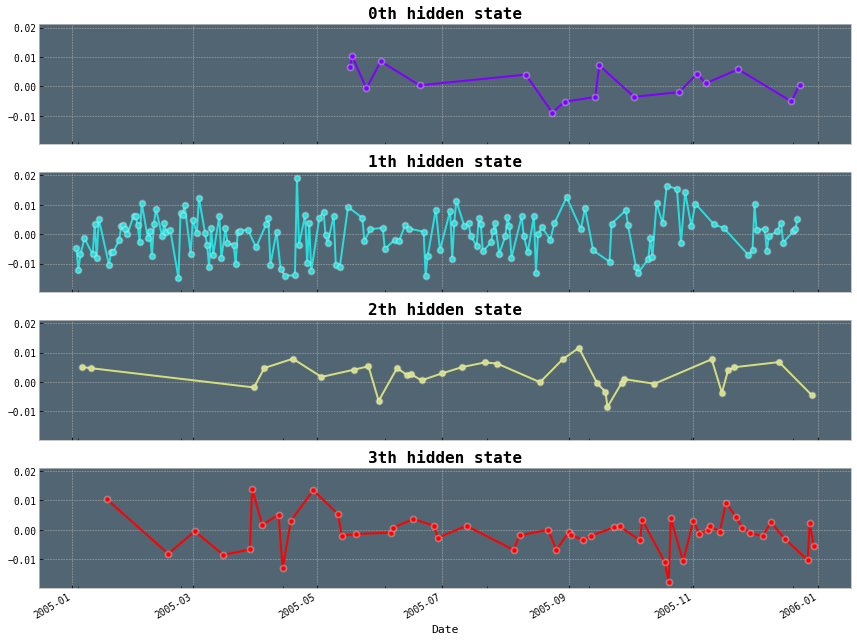

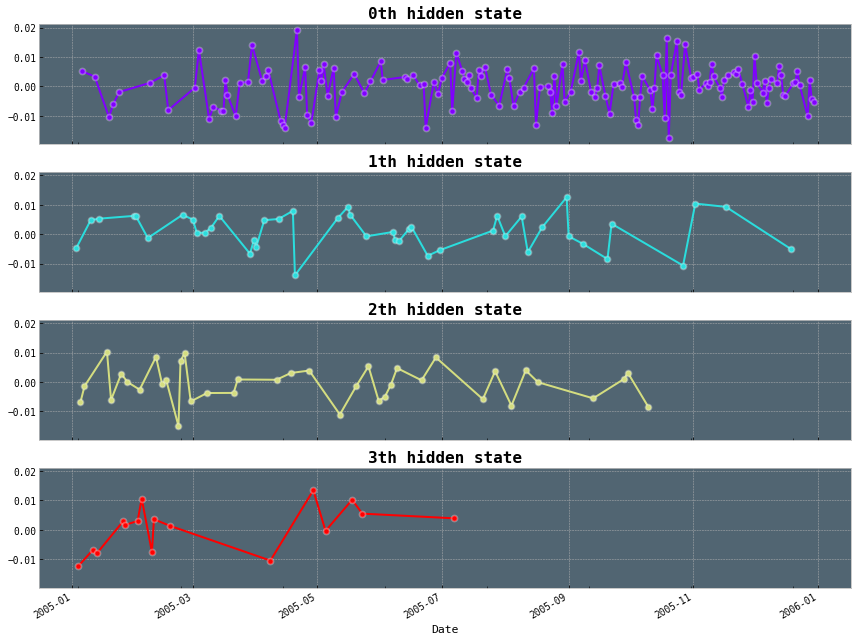

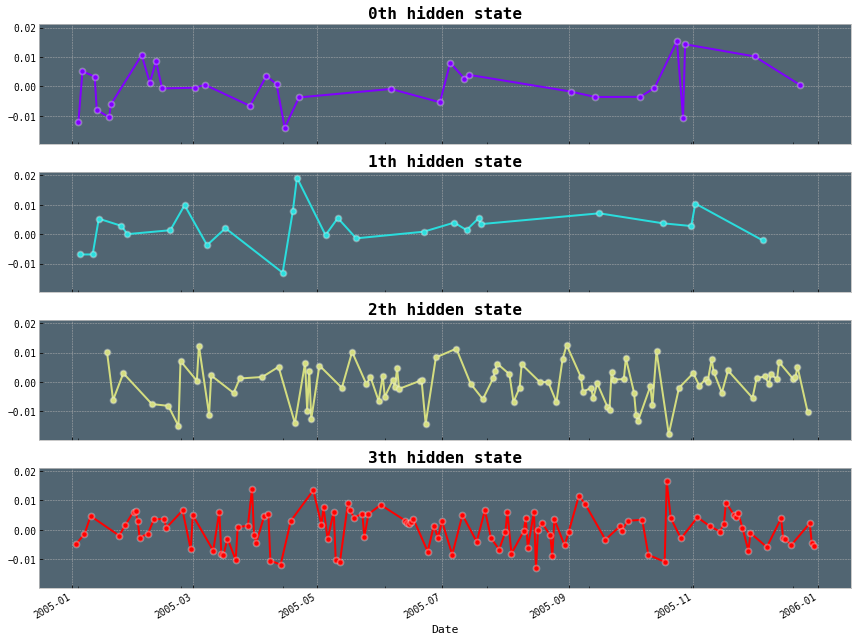

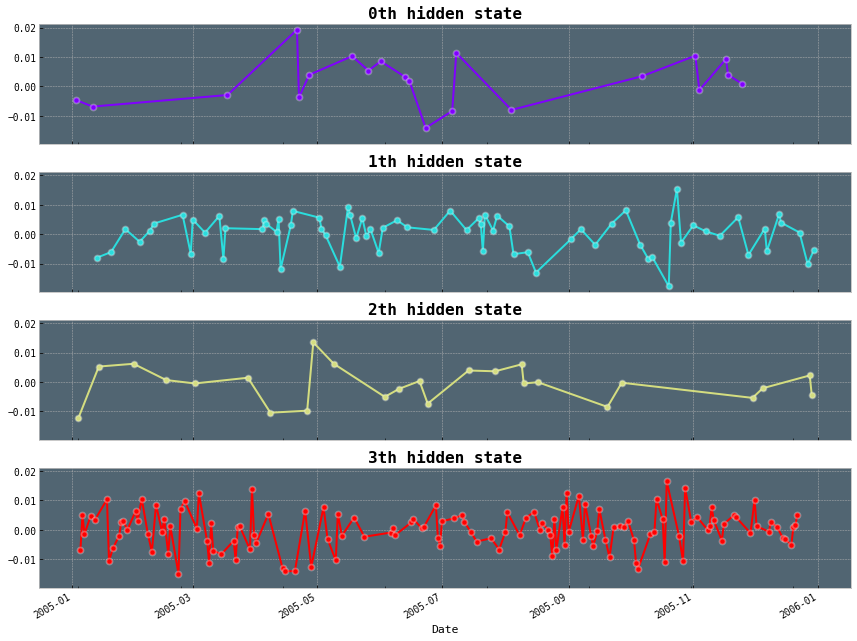

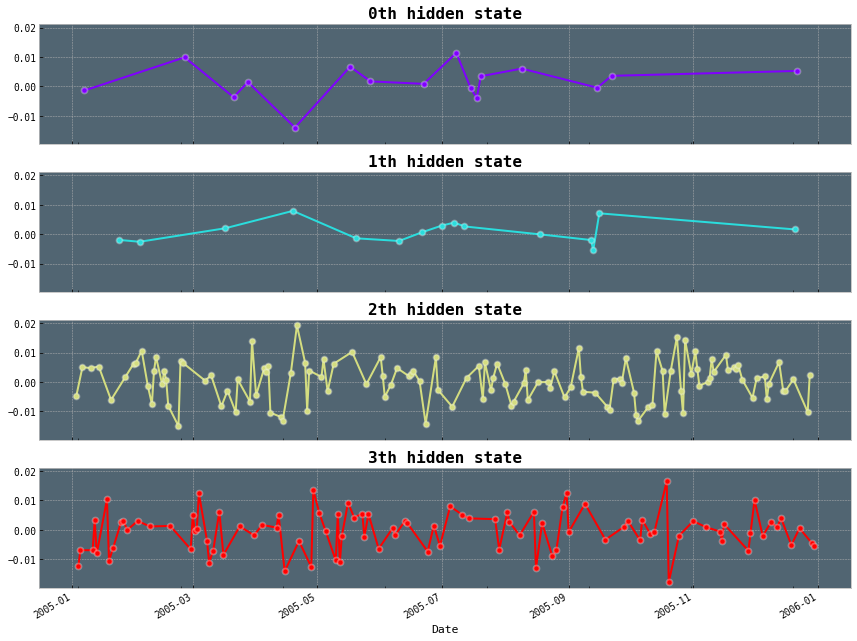

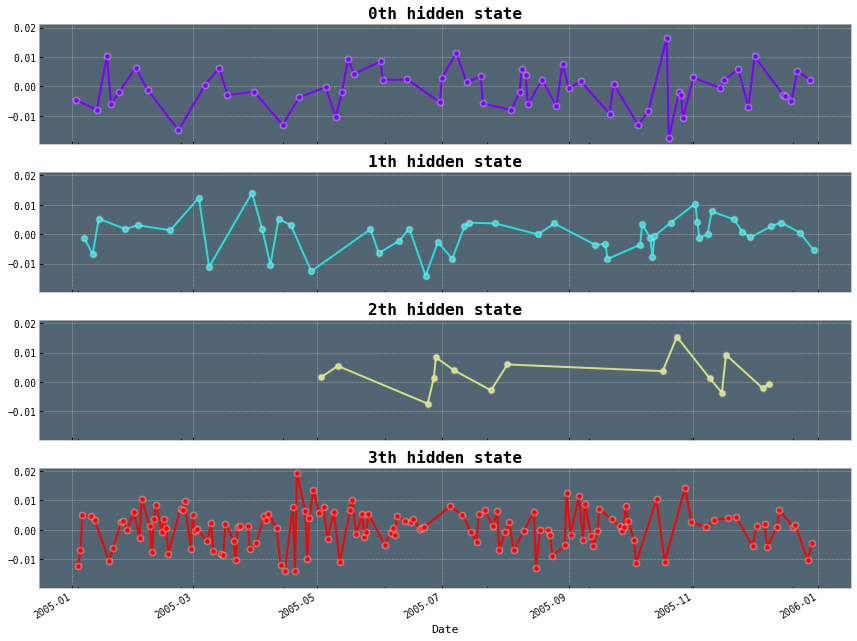

In [26]:


#xx = df[ex].copy() # pd series representing example data

_base = 252 # 1 trading year
_max_train_sizes = [_base*1, _base*2, _base*3, _base*5] # historical lookbacks
#_splits = np.arange(2, 12, 2)
_n_split=5 # try with different values

gs = gridspec.GridSpec(_n_split, len(_max_train_sizes), wspace=0.0)

fig = plt.figure(figsize=(20,25))

preds = []
pred_means = []
pred_covs = []

rows = []
#for j, max_size in enumerate(_max_train_sizes):
tscv = TimeSeriesSplit(n_splits=7, max_train_size=_base)

for i, (train, test) in enumerate(tscv.split(s)):
    tmp_train = X[train] # temporary train data
    tmp_test = X[test] # temporary test data

    gmm = make_gmm(4, max_iter)
    gmm.fit(tmp_train)
    
    hidden_states = gmm.predict(tmp_train)
    
    preds.append(hidden_states)
    pred_means.append(gmm.means_)
    pred_covs.append(gmm.covariances_)
    
    fig, axs = plt.subplots(gmm.n_components, sharex=True, sharey=True, figsize=(12,9))
    colors = plt.cm.rainbow(np.linspace(0, 1, gmm.n_components))

    for i, (ax, color) in enumerate(zip(axs, colors)):
        
        hs = pd.Series(hidden_states.copy())
        mask = hs[hs==i] # index locs of each state
        
        marker_edge_color = mpl.colors.colorConverter.to_rgba('white', alpha=.3)
        s[mask.index].plot(ax=ax, c=color, 
                           marker='o', markersize=6, 
                           markeredgecolor=marker_edge_color,
                           markeredgewidth=1.75)
        ax.set_facecolor(sns.xkcd_rgb['slate'])
        ax.set_title(f"{i}th hidden state", fontsize=16, fontweight='demi')

    plt.tight_layout()    

In [27]:
#(s.iloc[train].to_frame().assign(hidden_states=hidden_states).assign(mkt_cret=lambda df: df[sym].cumsum()).reset_index())

def make_state_df(hidden_states, s):
    states = (pd.DataFrame(hidden_states, columns=['states'], index=tmp_s.index)
              .join(s, how='inner')
              .assign(mkt_cret=tmp_s.cumsum())
              .reset_index(drop=False))
    return states
    
def plot_cuml_state(states, state_col=None):
    g = (pn.ggplot(states, pn.aes(x='Date',y='mkt_cret', color=f'factor({state_col})')) 
         + pn.geom_point(pn.aes(shape=f'factor({state_col})'))
         + pn.scale_y_continuous(breaks=mzb.mpl_breaks(),
                                 labels=mzf.percent_format(),
                                 limits=(states['mkt_cret'].min(), states['mkt_cret'].max()))
         + pn.theme_linedraw()
         + pn.theme(panel_background=pn.element_rect(fill='black'), 
                    axis_text_x=pn.element_text(rotation=30),) 
         + pn.ylab('log returns')
         + pn.ggtitle('Cumulative Log Returns by Hidden State'))
    return g

def plot_facet_cuml_states(states, state_col=None):
    g = (pn.ggplot(states, pn.aes(x='Date',y='mkt_cret', color=f'factor({state_col})')) 
         + pn.geom_point(pn.aes(shape=f'factor({state_col})'))
         + pn.geom_hline(yintercept=0., size=1, linetype=':', color='red')         
         #+ pn.stat_smooth(method='loess')
         + pn.facet_wrap(f'~{state_col}')
         + pn.scale_y_continuous(breaks=mzb.mpl_breaks(),
                                 labels=mzf.percent_format(),
                                 limits=(states['mkt_cret'].min(), states['mkt_cret'].max()))
         + pn.theme_linedraw()
         + pn.theme(panel_background=pn.element_rect(fill='black'), 
                    axis_text_x=pn.element_text(rotation=30),) 
         + pn.ylab('log returns')
         + pn.ggtitle('Cumulative Log Returns by Hidden State'))
    return g

def plot_facet_states(states, state_col=None):
    g = (pn.ggplot(states, pn.aes(x='Date', y=sym, color=f'factor({state_col})')) 
         + pn.geom_point(pn.aes(shape=f'factor({state_col})'))
         + pn.stat_smooth(method='lowess')
         + pn.facet_wrap(f'~{state_col}')
         + pn.scale_y_continuous(breaks=mzb.mpl_breaks(),
                                 labels=mzf.percent_format(),
                                 limits=(states['mkt_cret'].min(), states['mkt_cret'].max()))
         + pn.theme_linedraw()
         + pn.theme(panel_background=pn.element_rect(fill='black'), 
                    axis_text_x=pn.element_text(rotation=30),) 
         + pn.ylab('log returns')
         + pn.ggtitle('Cumulative Log Returns by Hidden State'))
    return g


*****************************************************************************


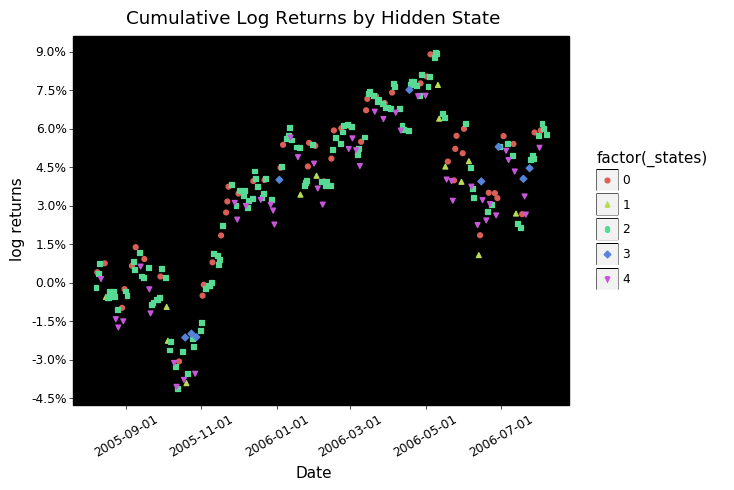

<ggplot: (-9223363309829530631)>


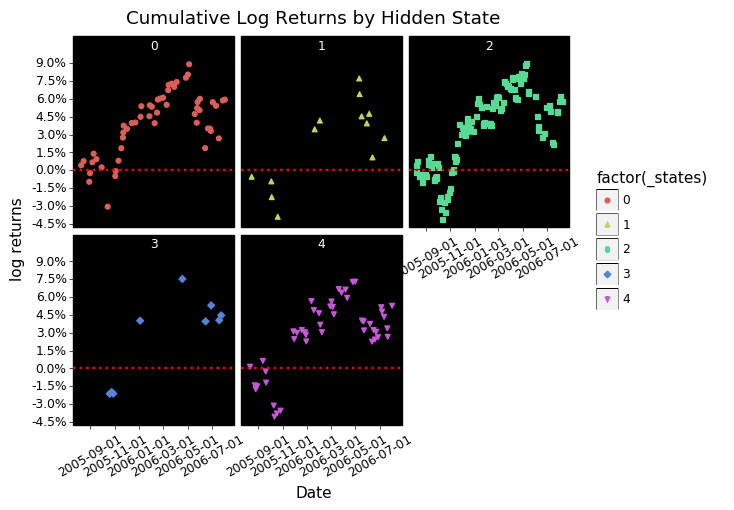

<ggplot: (8727025226230)>


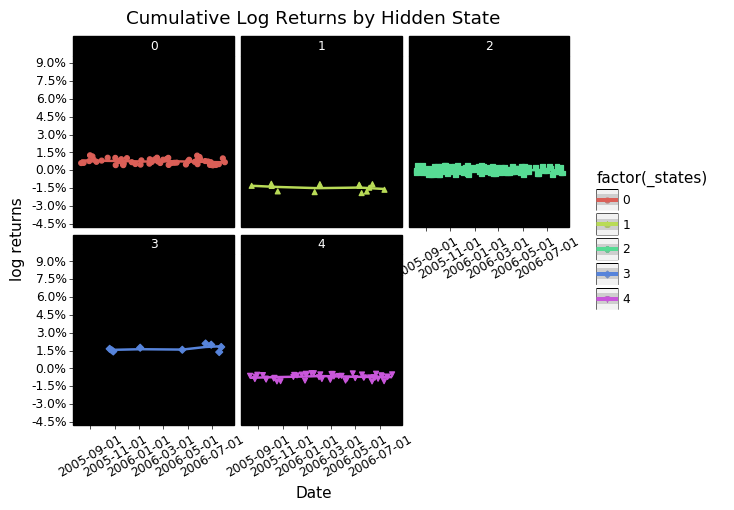

<ggplot: (-9223363309829568224)>


_states,0,1,2,3,4
count,53.000000,13.000000,129.000000,9.000000,48.000000
mean,0.007506,-0.014664,0.000295,0.016908,-0.007071
std,0.002276,0.002890,0.002202,0.002460,0.002030
min,0.004077,-0.019207,-0.003879,0.013779,-0.010909
25%,0.005763,-0.017773,-0.001468,0.015372,-0.008493
50%,0.007387,-0.013203,0.000230,0.016499,-0.006970
75%,0.009222,-0.012145,0.002026,0.018069,-0.005374
max,0.012560,-0.011320,0.003965,0.020992,-0.003952



*****************************************************************************


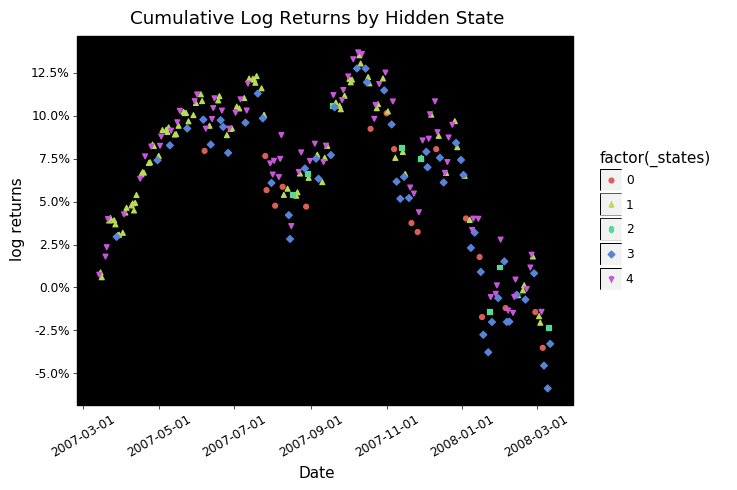

<ggplot: (-9223363309829635324)>


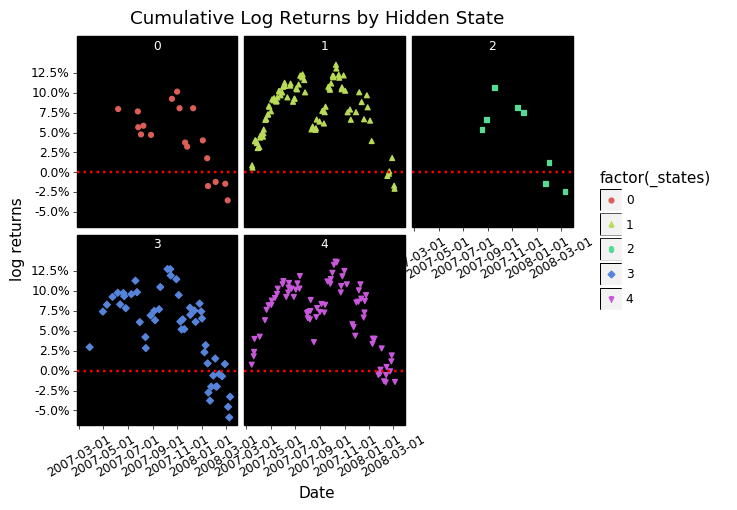

<ggplot: (-9223363309829530252)>


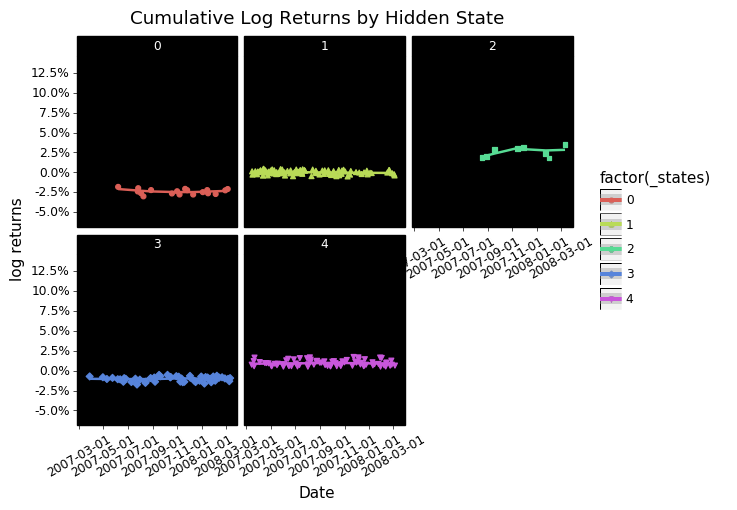

<ggplot: (-9223363309745747782)>


_states,0,1,2,3,4
count,18.000000,97.000000,8.000000,52.000000,77.000000
mean,-0.024059,0.000069,0.025659,-0.010403,0.009470
std,0.003200,0.002392,0.006687,0.002969,0.003542
min,-0.030081,-0.005083,0.018070,-0.017493,0.004861
25%,-0.026443,-0.001811,0.019124,-0.012888,0.006297
50%,-0.023825,0.000000,0.026376,-0.009893,0.009000
75%,-0.022234,0.002047,0.030389,-0.008271,0.011798
max,-0.018210,0.004552,0.035307,-0.005340,0.017145



*****************************************************************************


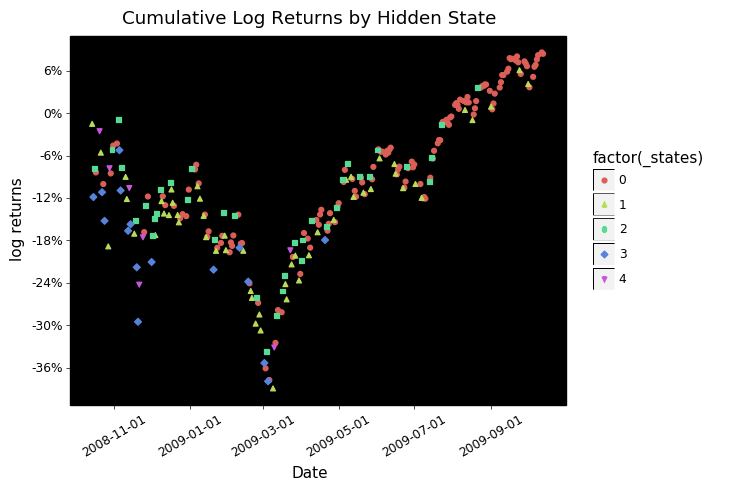

<ggplot: (8727025319407)>


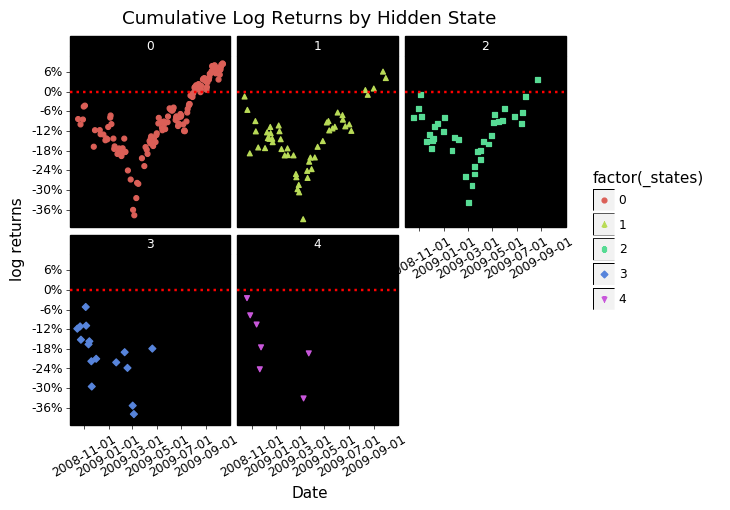

<ggplot: (8727025548110)>


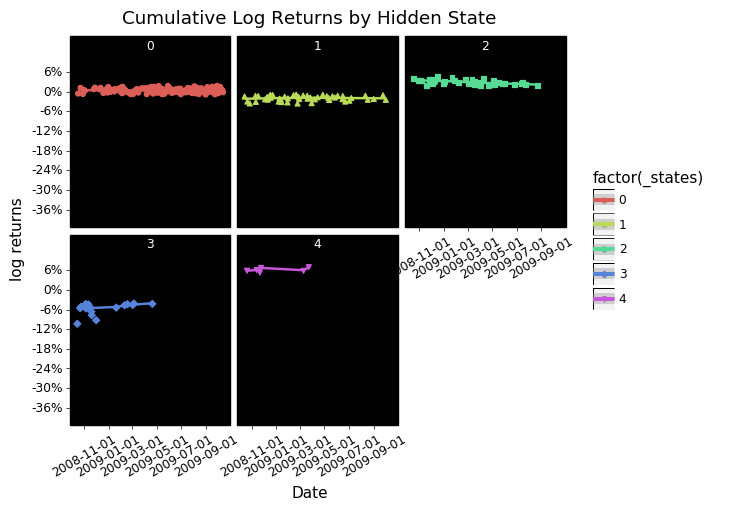

<ggplot: (-9223363309829334412)>


_states,0,1,2,3,4
count,140.000000,52.000000,37.000000,16.000000,7.000000
mean,0.003502,-0.019955,0.029046,-0.057461,0.068019
std,0.006737,0.007694,0.007494,0.018586,0.019585
min,-0.008939,-0.036434,0.018662,-0.103637,0.052538
25%,-0.002195,-0.024511,0.023065,-0.059310,0.058122
50%,0.003316,-0.018875,0.028818,-0.051620,0.060474
75%,0.008582,-0.013322,0.034009,-0.044678,0.068181
max,0.017745,-0.009507,0.045991,-0.041705,0.110517



*****************************************************************************


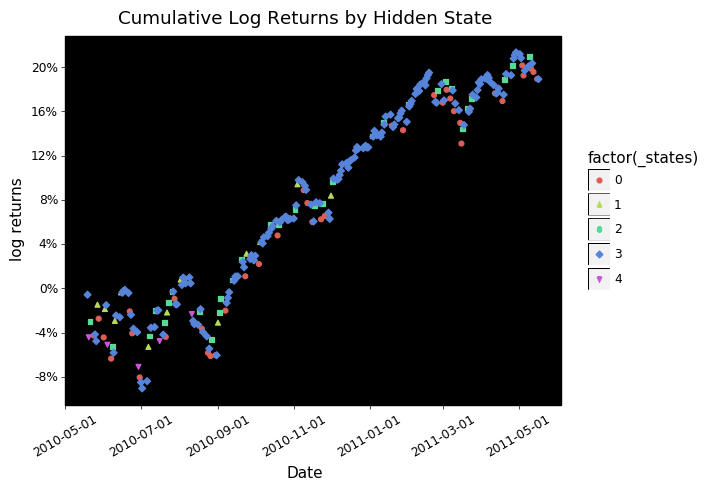

<ggplot: (-9223363309829283324)>


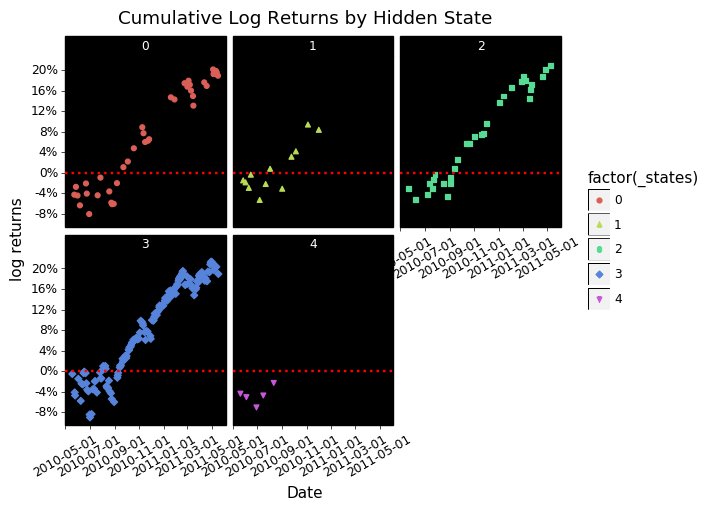

<ggplot: (-9223363309829377557)>


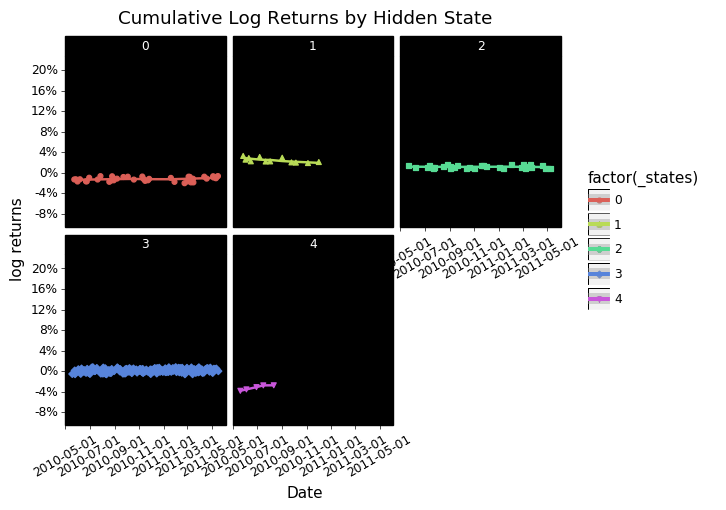

<ggplot: (8727024782428)>


_states,0,1,2,3,4
count,38.000000,12.000000,31.000000,166.000000,5.000000
mean,-0.012124,0.024609,0.011728,0.000918,-0.032266
std,0.004112,0.004786,0.002770,0.003557,0.004763
min,-0.020274,0.019075,0.007747,-0.006163,-0.038491
25%,-0.015515,0.020887,0.009394,-0.001580,-0.035769
50%,-0.011812,0.022406,0.011030,0.000737,-0.031362
75%,-0.007947,0.028977,0.014552,0.003731,-0.027921
max,-0.006362,0.032949,0.017077,0.007488,-0.027789



*****************************************************************************


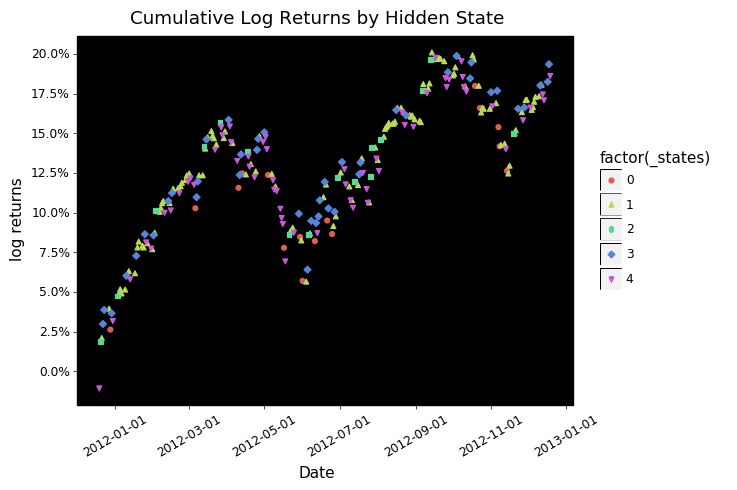

<ggplot: (-9223363309826371040)>


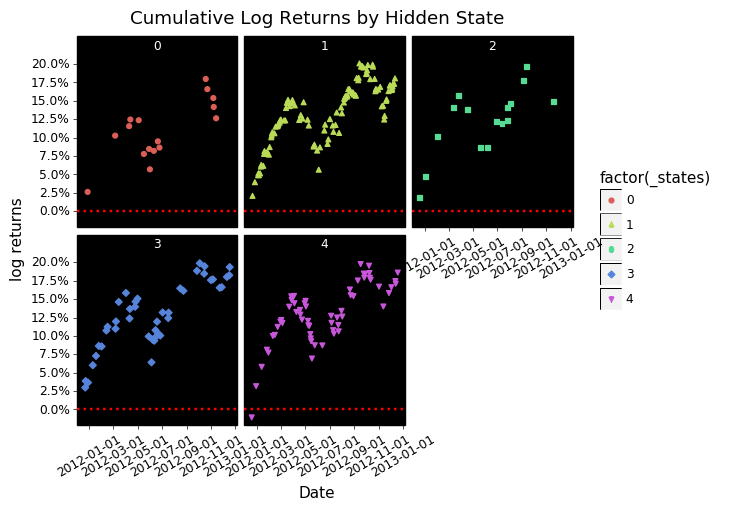

<ggplot: (8727028451434)>


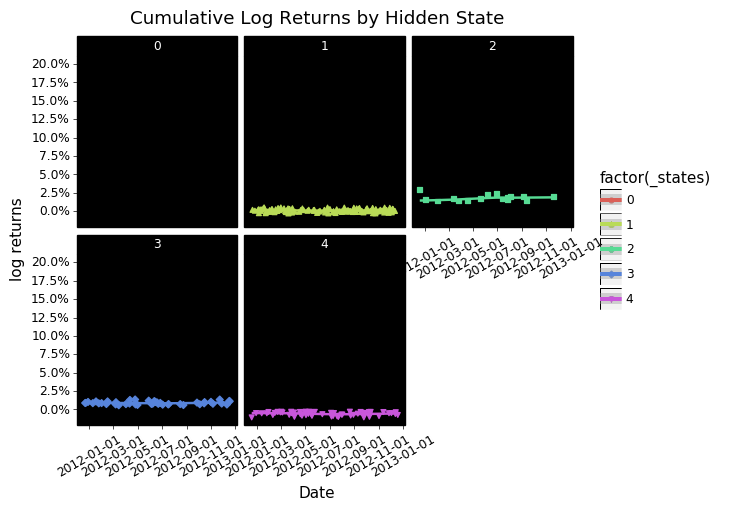

<ggplot: (8727025369643)>


_states,0,1,2,3,4
count,16.000000,117.000000,16.000000,43.000000,60.000000
mean,-0.016200,0.001078,0.018506,0.008956,-0.006035
std,0.004068,0.002089,0.004250,0.002052,0.002492
min,-0.025499,-0.002915,0.013921,0.005773,-0.011295
25%,-0.016836,-0.000468,0.015638,0.007366,-0.007794
50%,-0.014838,0.000796,0.017454,0.008633,-0.005412
75%,-0.013496,0.002636,0.020051,0.010349,-0.003805
max,-0.011960,0.005262,0.029812,0.013599,-0.002988



*****************************************************************************


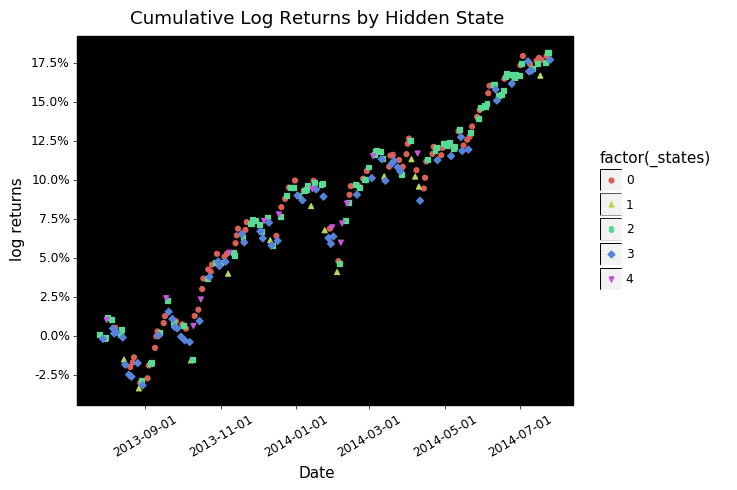

<ggplot: (8727024724877)>


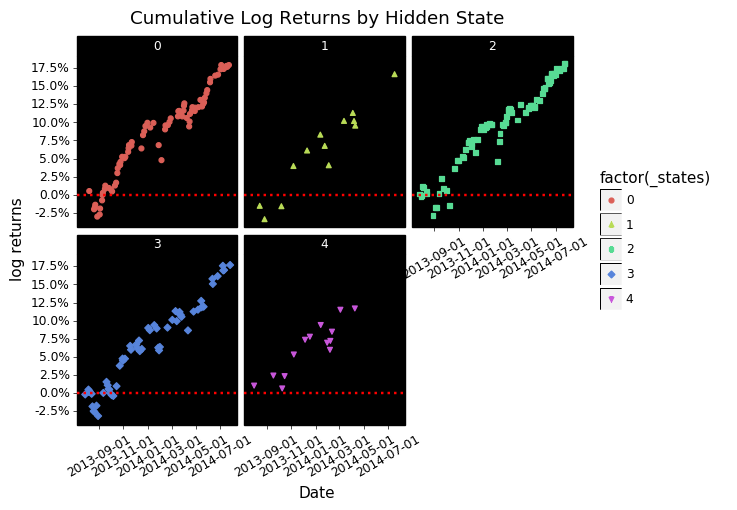

<ggplot: (8727025034623)>


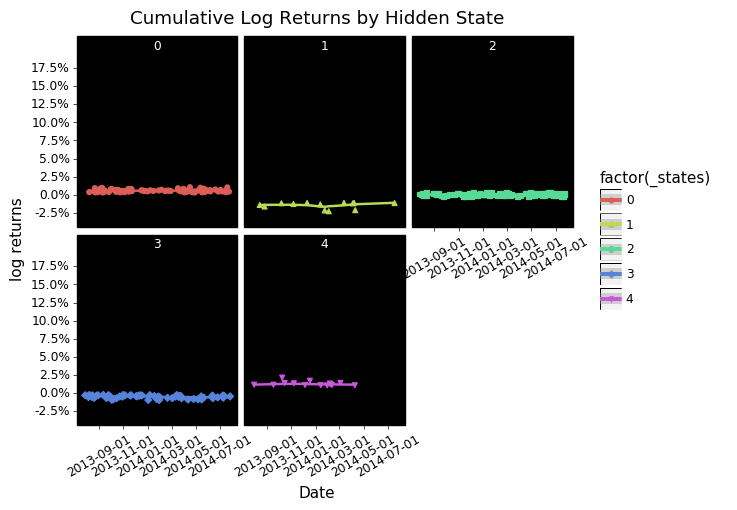

<ggplot: (8727109017373)>


_states,0,1,2,3,4
count,79.000000,13.000000,88.000000,58.000000,14.000000
mean,0.005708,-0.014669,0.000452,-0.005261,0.012999
std,0.001787,0.004347,0.001502,0.002059,0.002983
min,0.003133,-0.022762,-0.002600,-0.009652,0.010545
25%,0.004492,-0.016215,-0.000676,-0.006596,0.010942
50%,0.005320,-0.012724,0.000454,-0.004775,0.011913
75%,0.006701,-0.011431,0.001632,-0.003484,0.013752
max,0.010423,-0.011113,0.003044,-0.002660,0.021329



*****************************************************************************


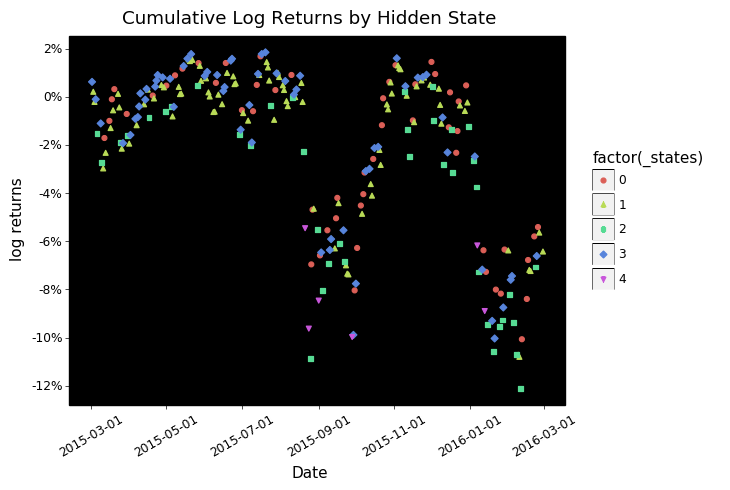

<ggplot: (-9223363309834465241)>


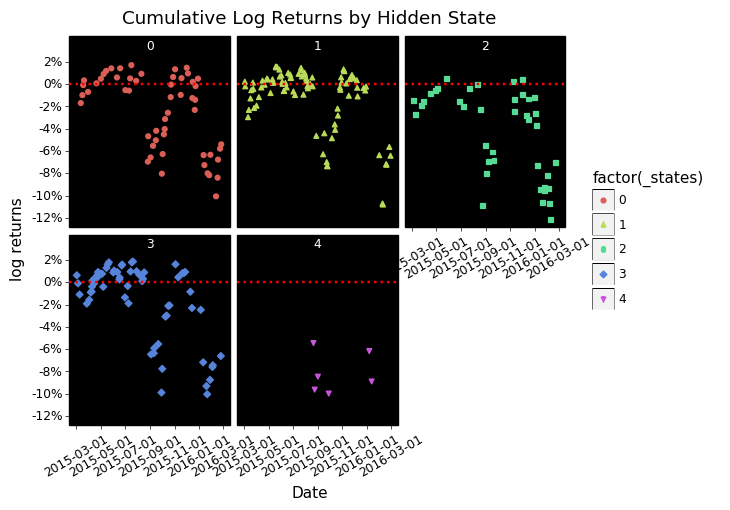

<ggplot: (-9223363309834478690)>


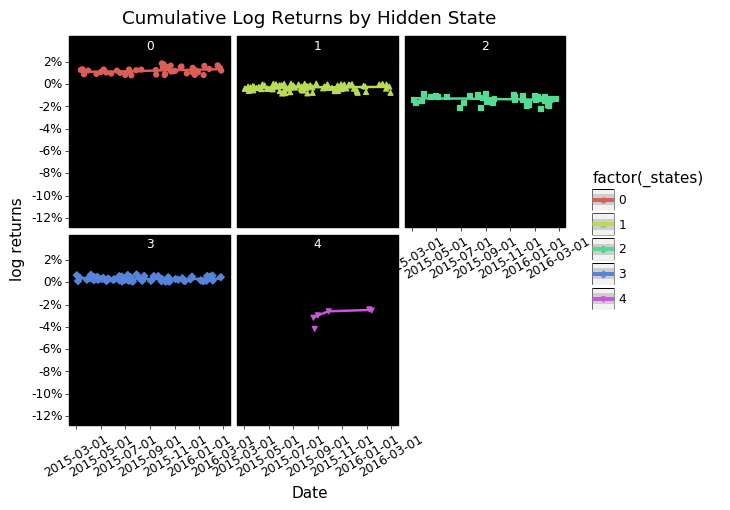

<ggplot: (-9223363309834501695)>


_states,0,1,2,3,4
count,54.000000,89.000000,40.000000,63.000000,6.000000
mean,0.013819,-0.003129,-0.013862,0.003195,-0.029792
std,0.005477,0.002397,0.003550,0.001831,0.006506
min,0.007756,-0.008482,-0.021700,0.000492,-0.041744
25%,0.010391,-0.004533,-0.015912,0.001453,-0.031240
50%,0.012439,-0.002943,-0.013323,0.002908,-0.027849
75%,0.016088,-0.001129,-0.011014,0.004566,-0.025456
max,0.039019,0.000402,-0.008569,0.006951,-0.024284


In [28]:
for i, (train, test) in enumerate(tscv.split(s)):
    tmp_train = s.iloc[train].reshape(-1,1) # temporary train data
    tmp_test = s.iloc[test].reshape(-1,1) # temporary test data

    gmm = make_gmm(5, max_iter)
    gmm.fit(tmp_train)
    
    hidden_states = gmm.predict(tmp_train)
    
    state_df = (s.iloc[train].to_frame()
                .assign(_states=hidden_states)
                .assign(mkt_cret=lambda df: df[sym].cumsum())
                .reset_index())
    
    preds.append(hidden_states)
    pred_means.append(gmm.means_)
    pred_covs.append(gmm.covariances_)
    
    scol = '_states'
    g = plot_cuml_state(state_df, state_col=scol)
    g1 = plot_facet_cuml_states(state_df, state_col=scol)
    g2 = plot_facet_states(state_df, state_col=scol)
    print()
    print('*'*77)
    print(g);
    print(g1);
    print(g2)
    display(state_df.groupby(scol)[sym].describe().T)
    #break

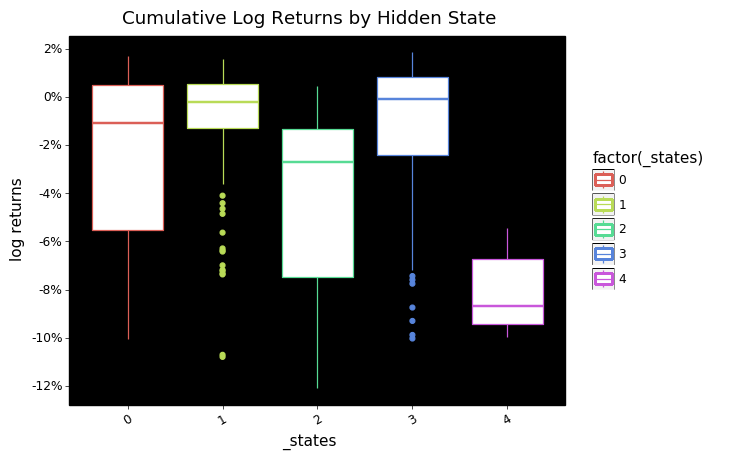

<ggplot: (8727024984121)>

In [29]:
def boxplot_states(states, state_col):
    g = (pn.ggplot(states, pn.aes(x=state_col,y='mkt_cret', color=f'factor({state_col})')) 
         + pn.geom_boxplot()#pn.aes(shape=f'factor({state_col})'))
         #+ pn.stat_smooth(method='loess')
         #+ pn.facet_wrap(f'~{state_col}')
         + pn.scale_y_continuous(breaks=mzb.mpl_breaks(),
                                 labels=mzf.percent_format(),
                                 limits=(states['mkt_cret'].min(), states['mkt_cret'].max()))
         + pn.theme_linedraw()
         + pn.theme(panel_background=pn.element_rect(fill='black'), 
                    axis_text_x=pn.element_text(rotation=30),) 
         + pn.ylab('log returns')
         + pn.ggtitle('Cumulative Log Returns by Hidden State'))
    return g

boxplot_states(state_df, scol)

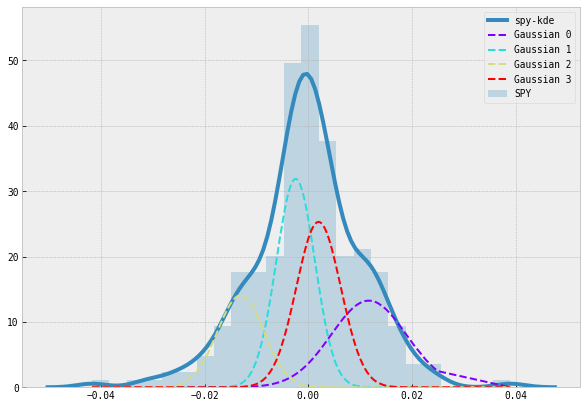

In [30]:
# reshape observed returns
x = state_df[sym].sort_values().reshape(-1,1)

# agg pdfs into list
agg_pdfs = [w * stats.norm.pdf(x, mu, sd) 
            for mu, sd, w in zip(gmm.means_, np.sqrt(gmm.covariances_), gmm.weights_)]
# sum density in case
summed_density = np.sum(np.array(agg_pdfs), axis=0)

# plot observed data distribution #and a single component gaussian fit aka norm fit
sns.distplot(x, hist=True, hist_kws=dict(alpha=0.25),
             kde=True, kde_kws=dict(lw=4, label='spy-kde'),
             #fit=stats.norm, fit_kws=dict(lw=2, label='spy-norm-fit', color='pink'),
             label=sym)

# plot component gaussians
for i, color in zip(range(len(agg_pdfs)), colors): plt.plot(x, agg_pdfs[i], ls='--', color=color, label=f'Gaussian {i}');  

plt.legend()

Note the difference between the SPY distribution fit with multiple Gaussians vs below with a single Gaussian fit.

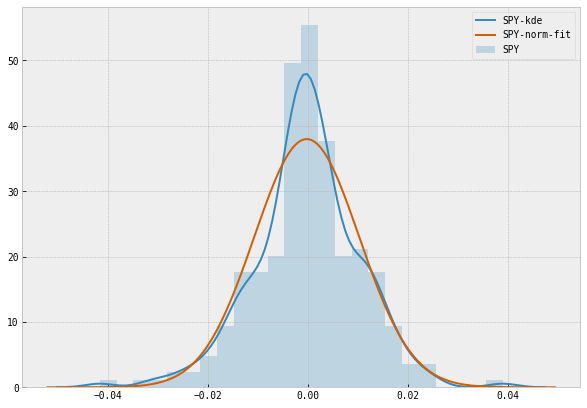

In [31]:
sns.distplot(x, hist=True, hist_kws=dict(alpha=0.25, label=f'{sym}-hist'),
             kde=True, kde_kws=dict(lw=2, label=f'{sym}-kde'),
             fit=stats.norm, fit_kws=dict(lw=2, color=red, label=f'{sym}-norm-fit'),
             label=sym)
plt.legend()

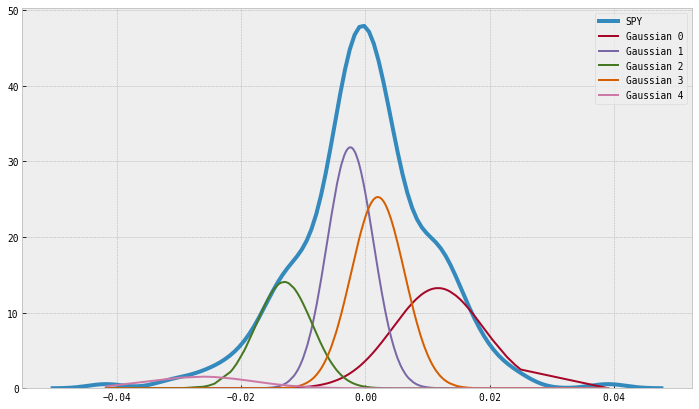

In [32]:
x = state_df[sym].sort_values().reshape(-1,1)

weights = gmm.weights_
means = gmm.means_
covars = gmm.covariances_

agg_pdf = [weights[i]*stats.norm.pdf(x,means[i],np.sqrt(covars[i])) for i in range(len(weights))]

fig, ax = plt.subplots(figsize=(12,7))

sns.kdeplot(state_df[sym], ax=ax, linewidth=4)
for i, _ in enumerate(range(len(weights))):
    ax.plot(x,weights[i]*stats.norm.pdf(x,means[i],np.sqrt(covars[i])), label=f'Gaussian {i}')

ax.legend()

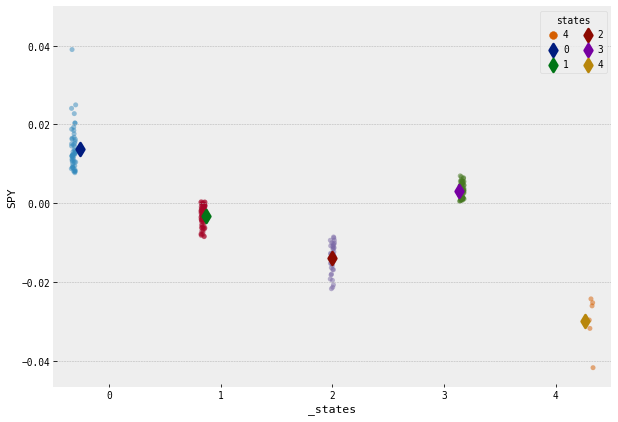

In [33]:
sym = 'SPY'
# Initialize the figure
f, ax = plt.subplots()
sns.despine(bottom=True, left=True)

# Show each observation with a scatterplot
sns.stripplot(x="_states", y=sym, hue="_states", data=state_df,
              dodge=True, jitter=True,
              alpha=.5, zorder=1)

# Show the conditional means
sns.pointplot(x="_states", y=sym, hue="_states", data=state_df,
              dodge=.532, join=False, palette="dark",
              markers="d", markersize=1, scale=1., ci=None)

# Improve the legend 
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[4:], labels[4:], title="states",
          handletextpad=0, columnspacing=1,
          loc="best", ncol=2, frameon=True)

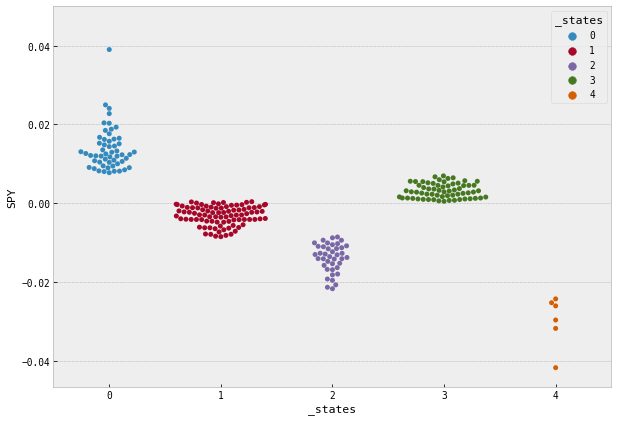

In [34]:
# Draw a categorical scatterplot to show each observation
sns.swarmplot(x="_states", y="SPY", hue="_states", data=state_df)